In [58]:
# Import the necessary libraries
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd

### Gathering Historical Data
We wll use the yfinance library in Python to fetch historical stock price data for NVIDIA (NVDA). This library allows us to download historical market data from Yahoo Finance.

In [59]:
# Define the stock ticker symbol
ticker_symbol = 'NVDA'

# Create a ticker object
ticker_data = yf.Ticker(ticker_symbol)

# Calculate dates: from today to ten years ago
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=365*10)).strftime('%Y-%m-%d')

# Fetch historical data
historical_data = ticker_data.history(period='1d', start=start_date, end=end_date)

In [60]:
# Print the shape of the fetched data
print(f"Shape of the fetched data: {historical_data.shape}")

# Display first few rows of the data
historical_data.head()

Shape of the fetched data: (2513, 7)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-01-21 00:00:00-05:00,3.776101,3.809121,3.745439,3.785535,24607600,0.0,0.0
2014-01-22 00:00:00-05:00,3.792612,3.797329,3.736006,3.780819,33794000,0.0,0.0
2014-01-23 00:00:00-05:00,3.769025,3.809121,3.738363,3.766666,18502800,0.0,0.0
2014-01-24 00:00:00-05:00,3.736006,3.750157,3.669965,3.669965,24669600,0.0,0.0
2014-01-27 00:00:00-05:00,3.669964,3.721853,3.625151,3.646378,23381200,0.0,0.0


<Axes: xlabel='Date'>

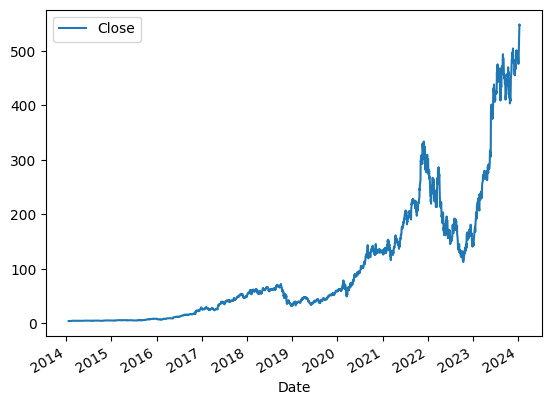

In [61]:
historical_data.plot(y="Close", use_index=True)

### Data Preprocessing
Once we have the data, the next step is to clean and preprocess it. This includes handling missing values, filtering the relevant columns (like date, open, high, low, close, volume)

In [62]:
# Delete unnecessary columns
del historical_data["Stock Splits"]
del historical_data["Dividends"]
historical_data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2014-01-21 00:00:00-05:00,3.776101,3.809121,3.745439,3.785535,24607600
2014-01-22 00:00:00-05:00,3.792612,3.797329,3.736006,3.780819,33794000
2014-01-23 00:00:00-05:00,3.769025,3.809121,3.738363,3.766666,18502800
2014-01-24 00:00:00-05:00,3.736006,3.750157,3.669965,3.669965,24669600
2014-01-27 00:00:00-05:00,3.669964,3.721853,3.625151,3.646378,23381200


In [63]:
# 1. Handling Missing Values
# Check for missing values
print("Missing values in each column:\n", historical_data.isnull().sum())

Missing values in each column:
 Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [64]:
# Create the target variable
# Calculate the price change
historical_data['Price_Change'] = historical_data['Close'].diff()

# 1 if the price increased, 0 if it decreased or stayed the same
historical_data['Target'] = (historical_data['Price_Change'] > 0).astype(int)

# Drop the first row as it will have a NaN value for Price_Change
historical_data.dropna(subset=['Price_Change'], inplace=True)

# Display the data
historical_data.tail()

,Open,High,Low,Close,Volume,Price_Change,Target
Date,,,,,,,
2024-01-08 00:00:00-05:00,495.119995,522.750000,494.790009,522.530029,64251000,31.560028,1
2024-01-09 00:00:00-05:00,524.010010,543.250000,516.900024,531.400024,77310000,8.869995,1
2024-01-10 00:00:00-05:00,536.159973,546.000000,534.890015,543.500000,53379600,12.099976,1
2024-01-11 00:00:00-05:00,549.989990,553.460022,535.599976,548.219971,59675900,4.719971,1
2024-01-12 00:00:00-05:00,546.200012,549.700012,543.299988,547.099976,35247900,-1.119995,0


In [65]:
# Define features (X) and target (y)
X = historical_data[['Open', 'High', 'Low', 'Close', 'Volume']]
y = historical_data['Target']

# Split data into training and testing sets
test_size = 100  # Define the size of the test set
X_train = X.iloc[:-test_size]
y_train = y.iloc[:-test_size]
X_test = X.iloc[-test_size:]
y_test = y.iloc[-test_size:]

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [67]:
# Building RandomForest Model
rf_model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=100, random_state=42)

In [68]:
# Predicting and Evaluating the Model
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.98      0.59        41
           1       0.83      0.08      0.15        59

    accuracy                           0.45       100
   macro avg       0.63      0.53      0.37       100
weighted avg       0.67      0.45      0.33       100



In [69]:
y_preds = pd.Series(y_pred, index=y_test.index)

In [70]:
combined = pd.concat([y_test, y_preds], axis=1)
combined.head()

,Target,0
Date,,
2023-08-22 00:00:00-04:00,0,0
2023-08-23 00:00:00-04:00,1,0
2023-08-24 00:00:00-04:00,1,0
2023-08-25 00:00:00-04:00,0,0
2023-08-28 00:00:00-04:00,1,0


<Axes: xlabel='Date'>

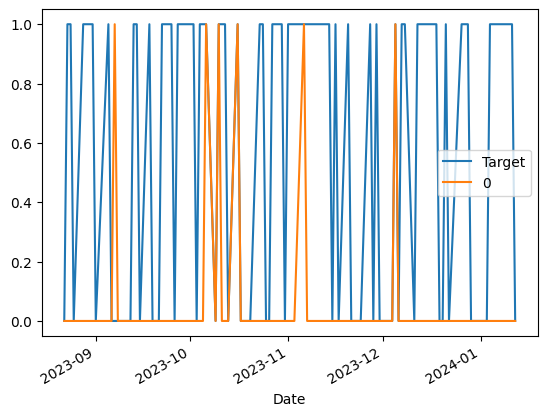

In [73]:
combined.plot()